In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input

In [2]:
img_width=256; img_height=256
batch_size=8
TRAINING_DIR = '../weather_pred/Data/training/'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 1274 images belonging to 5 classes.


In [3]:
VALIDATION_DIR = '../weather_pred/Data/validation/'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 226 images belonging to 5 classes.


In [4]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
# autosave best Model
best_model_file = '.../resnet101_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [5]:
resnet101_base = ResNet101(include_top=False, weights='imagenet',
                           input_tensor=None, input_shape=(img_height, img_width,3))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 88cf7a10940856eca736dc7b7e228a21 so we will re-download the data.
171458560/171446536 [==============================] - 50s 0us/step


In [6]:
print('Adding new layers...')
output = resnet101_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
# and a logistic layer -- let's say we have 4 classes
output = Dense(5, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [7]:
resnet101_model = Model(resnet101_base.input, output)
for layer in resnet101_model.layers[:-7]:
    layer.trainable = False

resnet101_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block7_out[0][0]']       
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block8_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block8_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block10_out[0][0]']      
                                                                                                  
 conv4_block11_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block13_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block13_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block13_out[0][0]']      
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block16_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block17_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block16_out[0][0]']      
                                                                                                  
 conv4_block17_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block17_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block17_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block17_1_bn[0][0]']     
 on)      

                                )                                 'conv4_block19_3_bn[0][0]']     
                                                                                                  
 conv4_block19_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block19_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block19_out[0][0]']      
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block22_add (Add)        (None, 16, 16, 1024  0           ['conv4_block21_out[0][0]',      
                                )                                 'conv4_block22_3_bn[0][0]']     
                                                                                                  
 conv4_block22_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block22_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block22_out[0][0]']      
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
          

 conv5_block2_3_bn (BatchNormal  (None, 8, 8, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 8, 8, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_blo

In [8]:
resnet101_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
history = resnet101_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_19960\2995577960.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet101_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 37s 172ms/step - loss: 0.6731 - accuracy: 0.7865 - val_loss: 0.2282 - val_accuracy: 0.9248
Epoch 2/30
160/160 [==============================] - 19s 119ms/step - loss: 0.3731 - accuracy: 0.8799 - val_loss: 0.1902 - val_accuracy: 0.9602
Epoch 3/30
160/160 [==============================] - 19s 120ms/step - loss: 0.3231 - accuracy: 0.9011 - val_loss: 0.1598 - val_accuracy: 0.9690
Epoch 4/30
160/160 [==============================] - 19s 120ms/step - loss: 0.2715 - accuracy: 0.9129 - val_loss: 0.1834 - val_accuracy: 0.9469
Epoch 5/30
160/160 [==============================] - 20s 123ms/step - loss: 0.2762 - accuracy: 0.9176 - val_loss: 0.1486 - val_accuracy: 0.9690
Epoch 6/30
160/160 [==============================] - 21s 130ms/step - loss: 0.2370 - accuracy: 0.9231 - val_loss: 0.1464 - val_accuracy: 0.9690
Epoch 7/30
160/160 [==============================] - 22s 139ms/step - loss: 0.2063 - accuracy: 0.9309 - val_loss: 0.1073 - val_ac

In [52]:
target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
resnet101_model.save(target_dir + 'resnet101_model.h5')
resnet101_model.save_weights(target_dir + 'resnet101_model.h5')

In [53]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

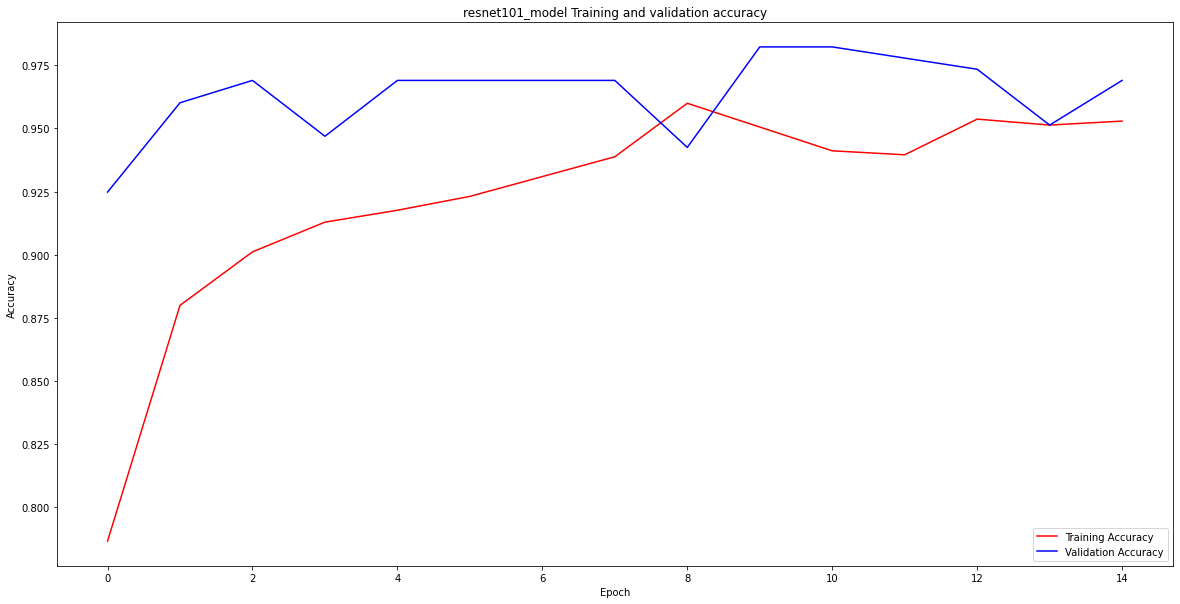

In [58]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('resnet101_model Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('resnet101_model.jpg')

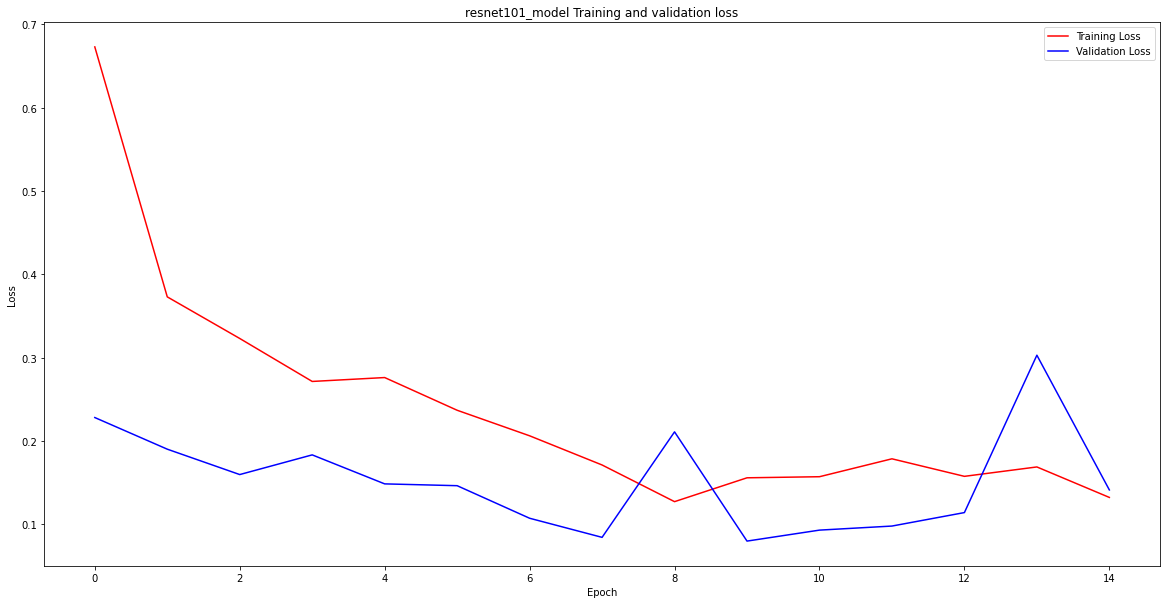

In [57]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('resnet101_model Training and validation loss')
fig2.savefig('resnet101_model_Loss.jpg')


### Test

In [56]:
import numpy as np
test_preprocessed_images = np.load('../test_preproc_res-net.npy')


In [16]:
#Prediction Function
array = resnet101_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

30/30 [==============================] - 2s 17ms/step


In [18]:
import pandas as pd
test_df = pd.read_csv('../dataset/test.csv')
y_true = test_df['labels']

In [19]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)

In [20]:
train_dir = '../weather_pred/Data/training/'
classes = os.listdir(train_dir)

In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        
    else:
        cm=cm
        
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

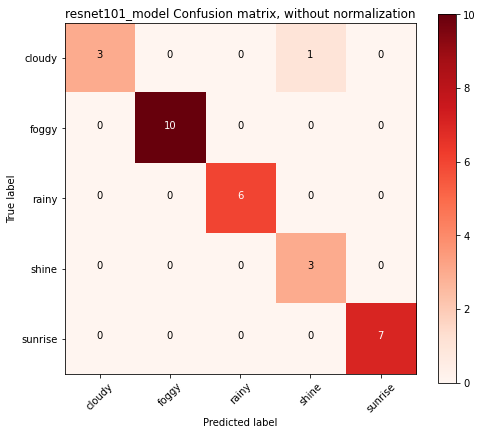

In [27]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='resnet101_model Confusion matrix, without normalization')
plt.show()

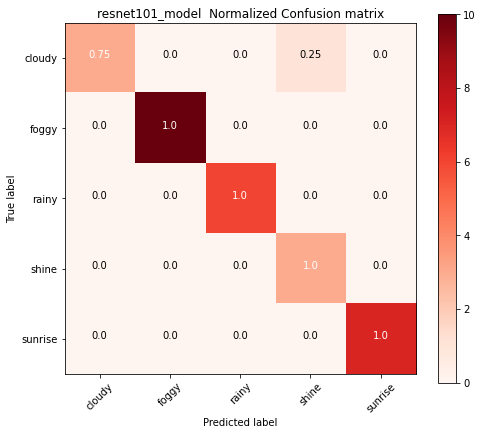

In [28]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='resnet101_model  Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      cloudy       1.00      0.75      0.86         4
       foggy       1.00      1.00      1.00        10
       rainy       1.00      1.00      1.00         6
       shine       0.75      1.00      0.86         3
     sunrise       1.00      1.00      1.00         7

    accuracy                           0.97        30
   macro avg       0.95      0.95      0.94        30
weighted avg       0.97      0.97      0.97        30



In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9666666666666667

In [29]:
from tensorflow.keras.applications.resnet import ResNet152

In [30]:
callbacks2 = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
best_model_file2 = '.../resnet152_drop_batch_best_weights_256.h5'
best_model2 = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [31]:
resnet152_base = ResNet152(include_top=False, weights='imagenet',
                           input_tensor=None, input_shape=(img_width, img_height,3))

234708992/234698864 [==============================] - 79s 0us/step


In [32]:
print('Adding new layers...')
output = resnet152_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(5, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [34]:
resnet152_model = Model(resnet152_base.input, output)
for layer in resnet152_model.layers[:-7]:
    layer.trainable = False
resnet152_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 32, 32, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 32, 32, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 16, 16, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 16, 16, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 16, 16, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 16, 16, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 16, 16, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 16, 16, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 8, 8, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 flatten_1 (Flatten)            (None, 131072)       0           ['conv5_block3_out[0][0]']       
                                                                                                  
 dense_3 (Dense)                (None, 1024)         134218752   ['flatten_1[0][0]']              
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 1024)        4096        ['dense_3[0][0]']                
 rmalization)                                                                                     
          

In [35]:
resnet152_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
history2 = resnet152_model.fit_generator(train_generator,
                                        epochs=30,
                                        verbose=1,
                                        validation_data=validation_generator,
                                        callbacks = [callbacks2, best_model2]
                                        )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_19960\1239925899.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = resnet152_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 32s 165ms/step - loss: 0.9296 - accuracy: 0.7936 - val_loss: 0.6504 - val_accuracy: 0.8540
Epoch 2/30
160/160 [==============================] - 24s 151ms/step - loss: 0.4570 - accuracy: 0.8728 - val_loss: 0.4033 - val_accuracy: 0.9027
Epoch 3/30
160/160 [==============================] - 24s 151ms/step - loss: 0.3793 - accuracy: 0.8901 - val_loss: 0.1293 - val_accuracy: 0.9513
Epoch 4/30
160/160 [==============================] - 24s 152ms/step - loss: 0.2703 - accuracy: 0.9152 - val_loss: 0.2281 - val_accuracy: 0.9292
Epoch 5/30
160/160 [==============================] - 25s 153ms/step - loss: 0.3646 - accuracy: 0.9011 - val_loss: 0.1811 - val_accuracy: 0.9513
Epoch 6/30
160/160 [==============================] - 24s 152ms/step - loss: 0.2309 - accuracy: 0.9309 - val_loss: 0.0924 - val_accuracy: 0.9779
Epoch 7/30
160/160 [==============================] - 24s 152ms/step - loss: 0.2082 - accuracy: 0.9325 - val_loss: 0.3436 - val_ac

In [36]:
target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
resnet152_model.save(target_dir + 'Res-net152_model.h5')
resnet152_model.save_weights(target_dir + 'Res-net152_weights.h5')

In [37]:
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc))

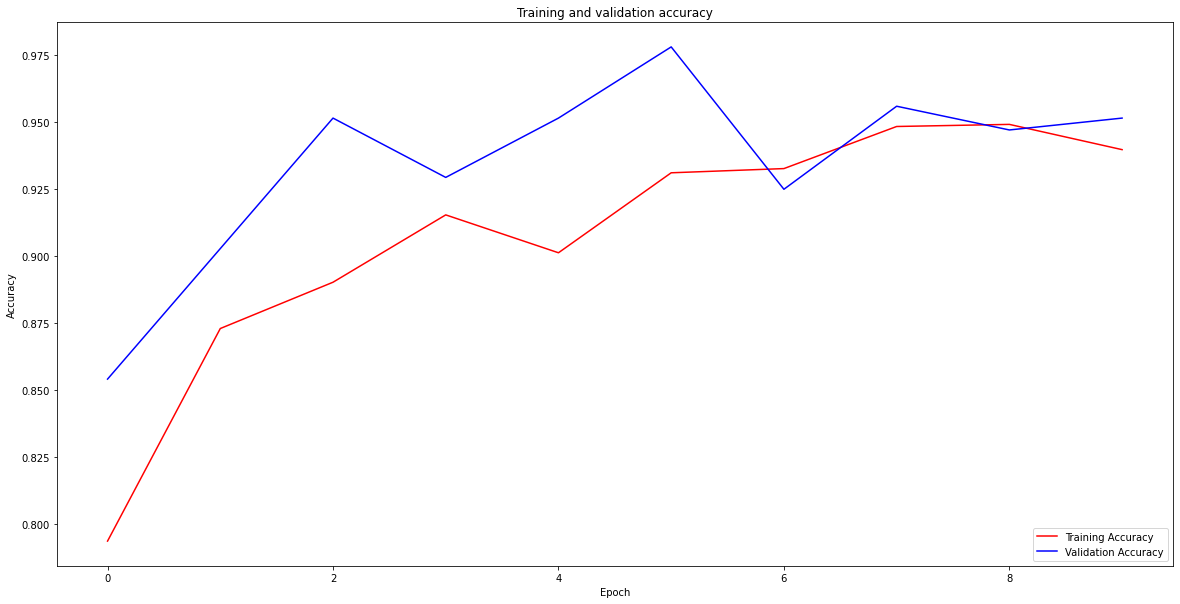

In [38]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Res-net152_model.jpg')

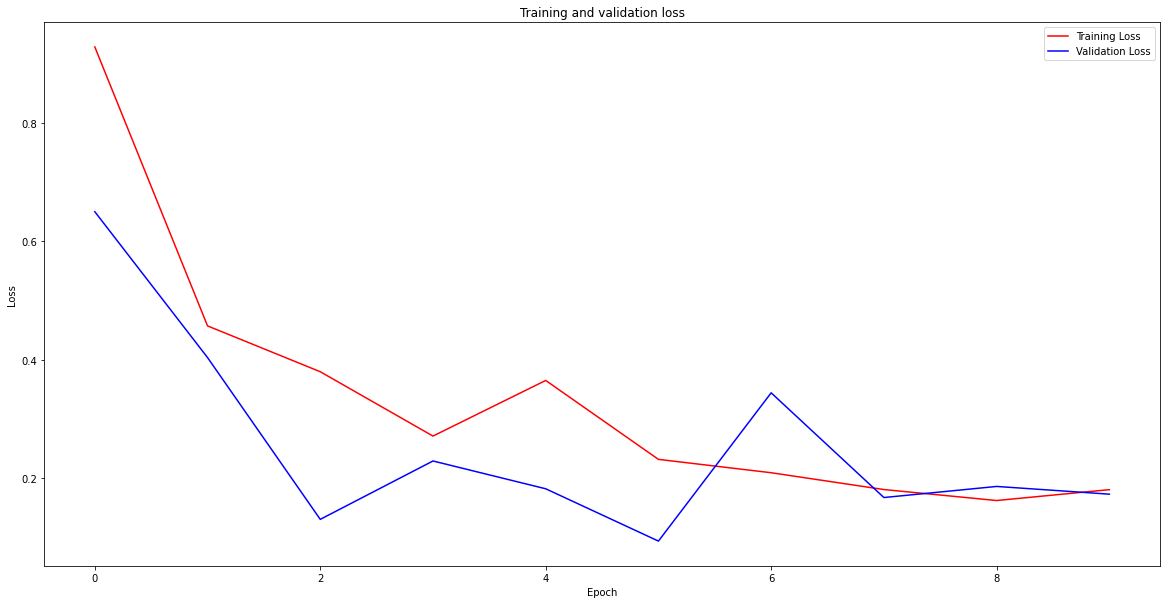

In [39]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
fig2.savefig('Res-net152_model.jpg')


In [45]:
#Prediction Function
array2 = resnet152_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred2 = np.argmax(array2, axis=1)

30/30 [==============================] - 1s 27ms/step


In [46]:

conf_mat = confusion_matrix(y_true, y_pred2)

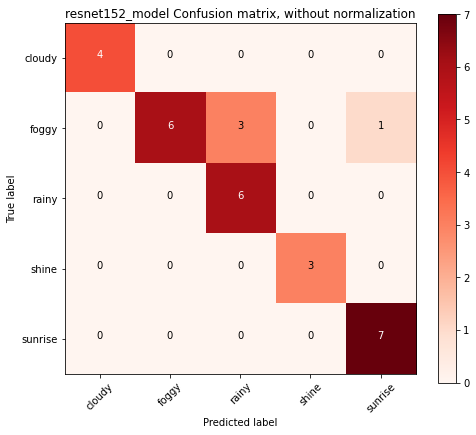

In [47]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='resnet152_model Confusion matrix, without normalization')
plt.show()

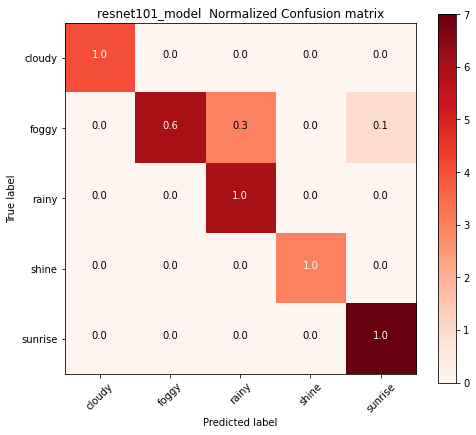

In [48]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='resnet101_model  Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred2, target_names=classes))



              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00         4
       foggy       1.00      0.60      0.75        10
       rainy       0.67      1.00      0.80         6
       shine       1.00      1.00      1.00         3
     sunrise       0.88      1.00      0.93         7

    accuracy                           0.87        30
   macro avg       0.91      0.92      0.90        30
weighted avg       0.90      0.87      0.86        30



In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred2)

0.8666666666666667